In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from torch import nn
import numpy as np

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
class EncodedDataset(Dataset):
    def __init__(self, final_embeddings, final_labels):
        super().__init__()
        self.final_embeddings = final_embeddings
        self.final_labels = final_labels
    
    def __getitem__(self, index):
        return (
            self.final_embeddings[index],
            self.final_labels[index],
        )

    def __len__(self):
        return self.final_embeddings.shape[0]

# Autoencoder

In [5]:
import torch
from src.mnist_autoencoder import Autoencoder, train
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

In [6]:
mnist_data = datasets.MNIST(
    "data", train=True, download=True, transform=transforms.ToTensor()
)
mnist_data_encoder = list(mnist_data)[:4096]

In [7]:
train_loader = torch.utils.data.DataLoader(
        mnist_data_encoder, batch_size=64, shuffle=True
    )

In [8]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, train_loader, num_epochs=max_epochs)

Epoch:1, Loss:0.0735
Epoch:2, Loss:0.0631
Epoch:3, Loss:0.0541
Epoch:4, Loss:0.0350
Epoch:5, Loss:0.0247
Epoch:6, Loss:0.0225
Epoch:7, Loss:0.0180
Epoch:8, Loss:0.0143
Epoch:9, Loss:0.0131
Epoch:10, Loss:0.0121
Epoch:11, Loss:0.0131
Epoch:12, Loss:0.0110
Epoch:13, Loss:0.0098
Epoch:14, Loss:0.0097
Epoch:15, Loss:0.0086
Epoch:16, Loss:0.0086
Epoch:17, Loss:0.0076
Epoch:18, Loss:0.0077
Epoch:19, Loss:0.0070
Epoch:20, Loss:0.0072


# Train and sample datasets

In [9]:
sample_mnist_data_clf = list(mnist_data)[4096:4096*2]

In [10]:
train_mnist_data_clf = list(mnist_data)[4096*2:int(4096*4)]

# train

In [11]:
from src.gat_classifier import Net

In [41]:
n = Net(num_classes=10,
        encoder_model=model,
        sample_dataset=sample_mnist_data_clf,
        train_dataset=train_mnist_data_clf,
        num_epochs=20,
        learning_rate=1e-3,
        seed=42,
        use_graph=True)

In [42]:
loss = n.train()

100%|██████████| 128/128 [00:07<00:00, 17.91it/s]


In [43]:
# torch.optim.Adam()

In [44]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
all_losses = []
index = 0
for i,x in enumerate(loss):
    for j,y in enumerate(x):
        all_losses.append({"counter":index,"epoch":i+1,"iteration":j+1,"loss":y})
        index+=1

In [46]:
loss_df = pd.DataFrame(all_losses)

<AxesSubplot:xlabel='counter', ylabel='loss'>

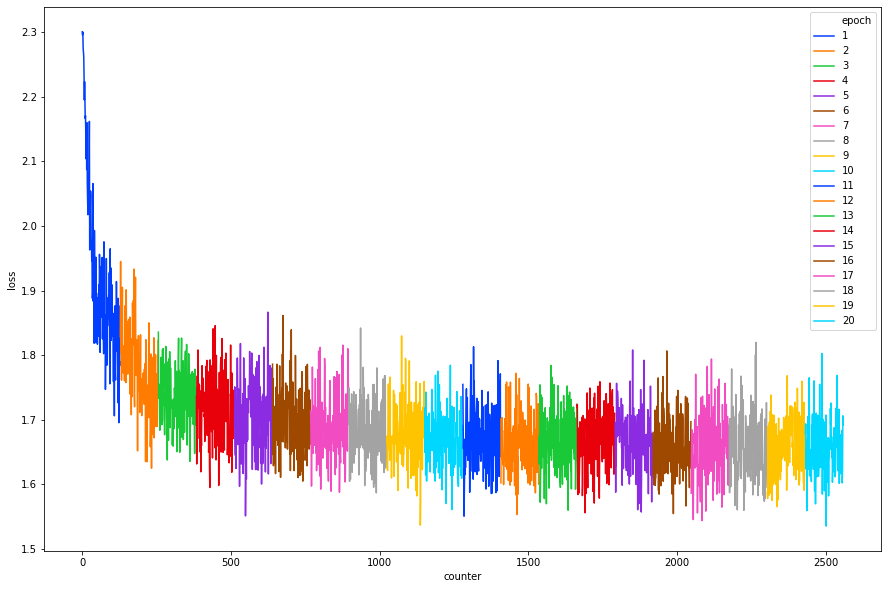

In [47]:
plt.figure(figsize=(15,10))
sns.lineplot(data=loss_df,x="counter",y="loss",hue="epoch",palette=sns.color_palette("bright",n_colors=len(loss_df.epoch.unique())))

In [233]:
mnist_data_clf_test = list(mnist_data)[4096*5:4096*6]

In [234]:
len(mnist_data_clf_test)

4096

In [235]:
clf_test_loader = n.get_encoding(mnist_data_clf_test,64)

In [236]:
from tqdm import tqdm

In [237]:
res = []
for data in tqdm(clf_test_loader):
    img, label = data
    recon = n.forward(img)
    _, preds = torch.max(recon, 1)
    bool_tensor = preds == label
    res.append(torch.stack([label,bool_tensor,preds],dim=1))

  0%|          | 0/64 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [64] at entry 0 and [1] at entry 2

In [ ]:
all_res = torch.cat(res,dim=0)

In [ ]:
import numpy as np

In [ ]:
df_test_res = pd.DataFrame(all_res.numpy(),columns=["class","res","pred_class"])

In [ ]:
# df_test_res.groupby(["class","res"]).agg({"res":len})

In [ ]:
confusion_matrix = pd.crosstab(df_test_res['class'], df_test_res['pred_class'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix